In [1]:
# TODO: ~/src/anaconda3/envs/tf/lib/python3.6/site-packages/textgenrnn.bak/

#from textgenrnn import textgenrnn
from textgenrnn.textgenrnn import textgenrnn, utils

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

def attention_map(prediction_text, x_lbls, weights):
    # https://github.com/datalogue/keras-attention/blob/master/visualize.py
    '''if '<pad>' in x_lbls:
        # replace "" after last "<pad>" with another "pad"
        last_pad = len(x_lbls) - 1 - x_lbls[::-1].index('<pad>')
        if last_pad + 1 < len(x_lbls):
            x_lbls[last_pad + 1] = '<pad>'''
            
    #print(prediction_text, x_lbls)
    
    # get the activation map
    activation_map = [a[0] for a in weights]

    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')

    # add labels
    ax.set_xticks(range(model_cfg['max_length']))
    ax.set_xticklabels([f'"{l}"' for l in x_lbls])

    ax.set_yticks(range(len(weights)))
    ax.set_yticklabels([f'"{t}"' for t in prediction_text])
    ax.yaxis.tick_right()

    ax.set_xlabel('History')
    ax.set_ylabel('Next word')

    #f.savefig(os.path.join(HERE, 'attention_maps', text.replace('/', '')+'.pdf'), bbox_inches='tight')
    return f, i
    
meta_token = '<s>'
pad_token = '<pad>'
    
def sample(textgen, temperature=0.5, map_attention=True, max_len=20, seed=None):
    # suppress runtime warning
    plt.rcParams.update({'figure.max_open_warning': max_len + 1})
    
    from keras.models import Model
    import re

    # https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    attn_model = Model(inputs=textgen.model.input, outputs=[textgen.model.get_layer('attention').output[1], textgen.model.output])
    
    next_word = ''
    text = [meta_token] + list(seed) if seed else [meta_token]
    last_lbls = [pad_token]*(model_cfg['max_length'] - 1) + [meta_token]
    attn_weights = []

    if map_attention:
        plt.clf()
    while next_word != meta_token and (len(text) + 1) < max_len:
        encoded_text = utils.textgenrnn_encode_sequence(text, textgen.vocab, model_cfg['max_length'])

        preds = attn_model.predict(encoded_text)
        attn = preds[0]
        full_pred = preds[1]

        next_index = utils.textgenrnn_sample(full_pred[0], temperature)
        next_word = textgen.indices_char[next_index]

        text += [next_word]
        
        if map_attention:
            attn_lbl = list([pad_token]*max(model_cfg['max_length']-len(text), 0) + text[-model_cfg['max_length']:])
            attention_map([next_word], last_lbls, [attn])
            attn_weights.append(attn)
            last_lbls = attn_lbl

    text_joined = ' '.join(text[1:])
    punct = '\\n\\t'
    print(f'temperature: {temperature}; max_len: {max_len}')
    print(re.sub(" ([{}]) ".format(punct), r'\1', text_joined))
    if map_attention:
        # add colorbar [left, bottom, width, height]
        f, i = attention_map(text[1:], [], attn_weights)
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Weight', labelpad=4)
        plt.show()


from keras.callbacks import Callback

class sample_after_epoch(Callback):
    def __init__(self, textgen, sample_epochs, temperature=0.5, map_attention=True, max_len=20):
        self.textgen = textgen
        self.sample_epochs = sample_epochs
        self.temperature = temperature
        self.map_attention = map_attention
        self.max_len = max_len

    def on_epoch_end(self, epoch, logs={}):
        if self.sample_epochs > 0 and (epoch+1) % self.sample_epochs == 0:
            sample(self.textgen, temperature=self.temperature, map_attention=self.map_attention, max_len=self.max_len)

In [3]:
model_cfg = {
    'rnn_size': 128,
    'rnn_layers': 4,
    'rnn_bidirectional': True,
    'max_length': 10,#5,#300,
    'max_words': 100000,
    'dim_embeddings': 300,
    'word_level': True,
}

train_cfg = {
    'line_delimited': True,
    'num_epochs': 1,#10,
    'gen_epochs': 0,#1,#2,
    'sample_epochs': 1,
    'batch_size': 512,
    'train_size': 0.8,
    'dropout': 0.1,
    'max_gen_length': 300,
    'validation': True,
    'is_csv': False
}

37,768 texts collected.
Training new model w/ 4-layer, 128-cell Bidirectional LSTMs
Training on 5,212,896 word sequences.
Epoch 1/1
10181/10181 [==============================] - 660s 65ms/step - loss: 4.4031 - val_loss: 4.0956
temperature: 0.5; max_len: 20
posted by : on december 21 , 2014 * * * * * * * i have a lot


<Figure size 432x288 with 0 Axes>

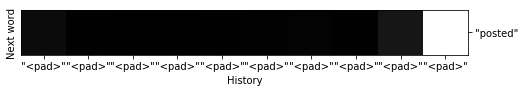

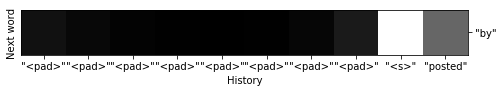

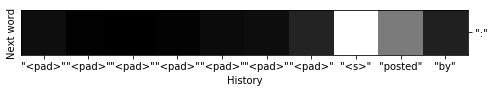

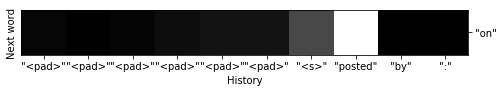

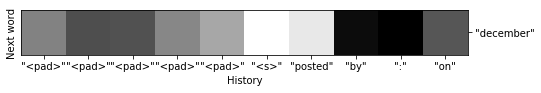

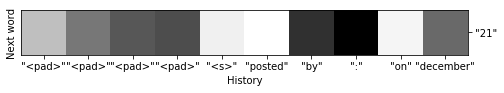

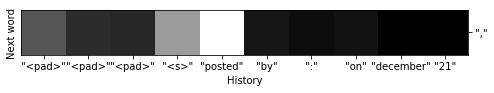

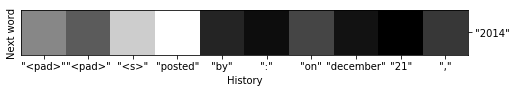

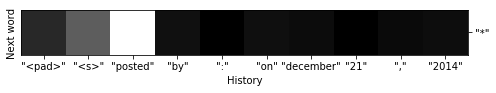

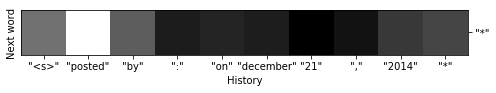

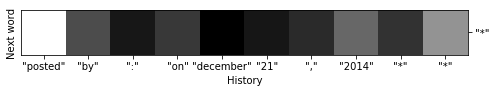

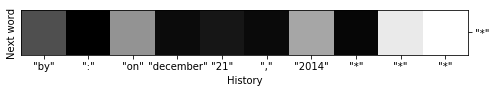

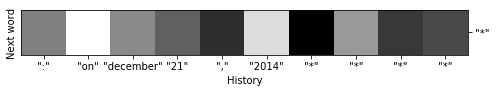

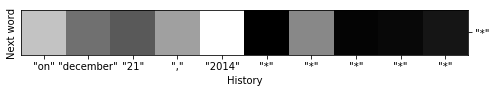

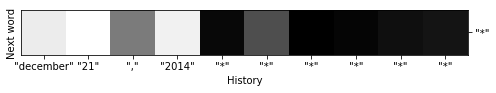

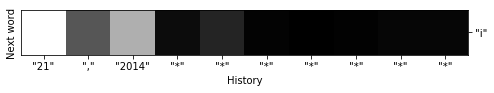

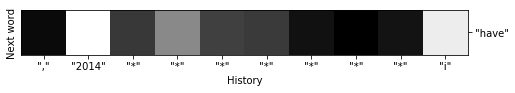

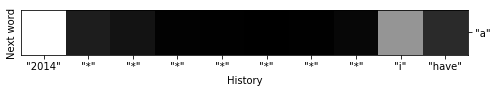

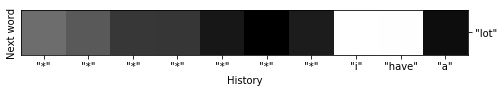

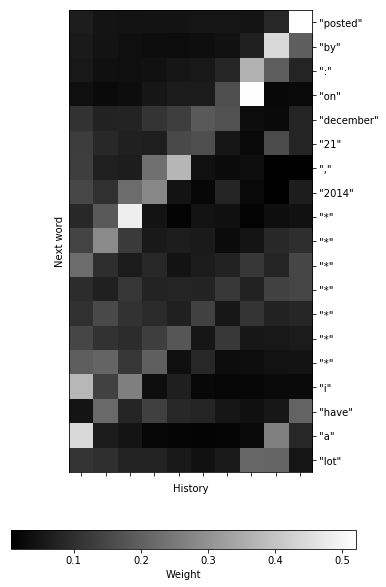

In [4]:
from pathlib import Path

data_path = Path('../datasets/')
model_name = 'reviews_lines'
textgen = textgenrnn(name=model_name)

train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file

train_function(
    file_path=str(data_path / f'{model_name}.txt'),
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'],
    callbacks=[sample_after_epoch(textgen, train_cfg['sample_epochs'])])

In [5]:
train_cfg['num_epochs'] = 10
train_cfg['sample_epochs'] = 2

37,768 texts collected.
Training on 4,156,529 word sequences.
Epoch 1/10
8118/8118 [==============================] - 533s 66ms/step - loss: 4.6423 - val_loss: 4.6592
Epoch 2/10
8118/8118 [==============================] - 520s 64ms/step - loss: 4.4112 - val_loss: 4.6503
temperature: 0.5; max_len: 20
posted march 2016 by tim kaplan under new music a little bit of a departure from the original and


<Figure size 432x288 with 0 Axes>

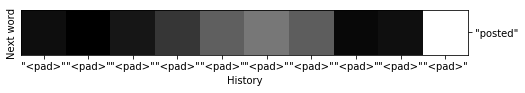

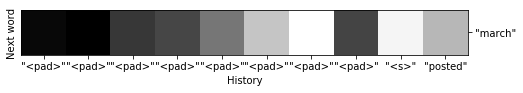

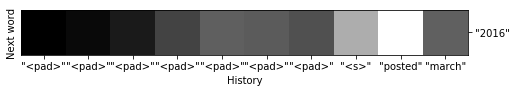

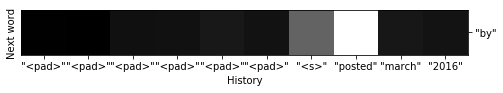

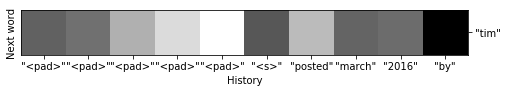

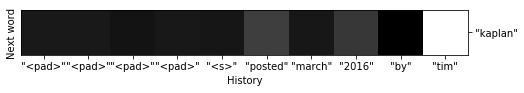

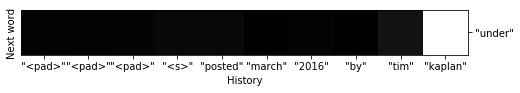

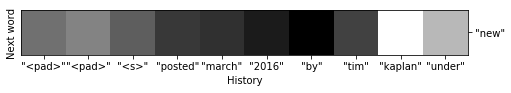

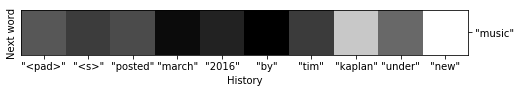

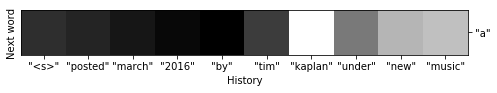

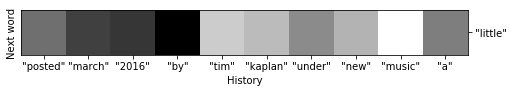

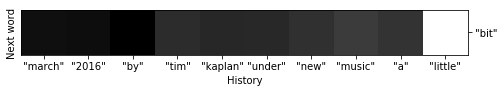

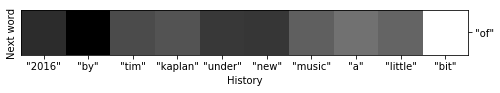

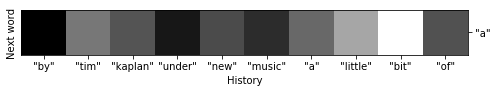

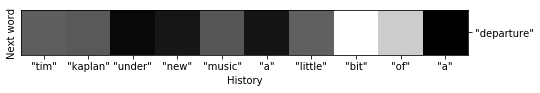

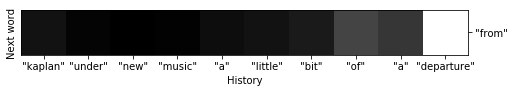

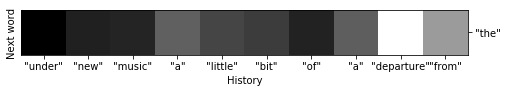

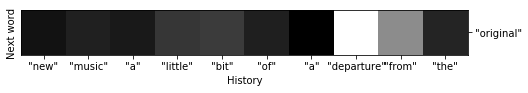

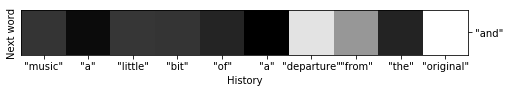

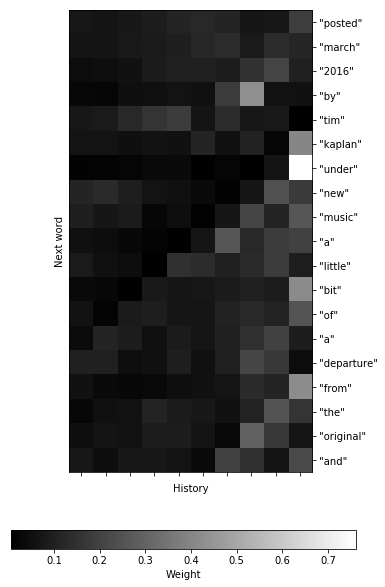

Epoch 3/10
8118/8118 [==============================] - 521s 64ms/step - loss: 4.2727 - val_loss: 4.6379
Epoch 4/10
8118/8118 [==============================] - 525s 65ms/step - loss: 4.1393 - val_loss: 4.7252
temperature: 0.5; max_len: 20
after his success with his debut single featuring the vocals of fellow aussie chance the rapper and social experiment


<Figure size 432x288 with 0 Axes>

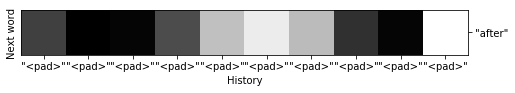

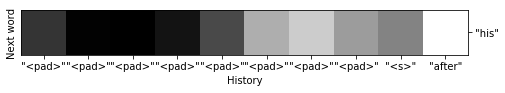

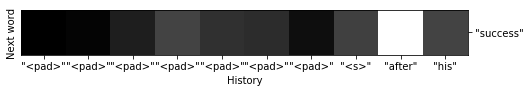

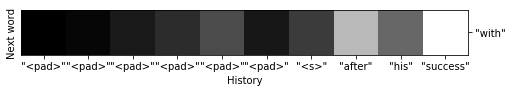

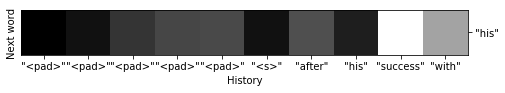

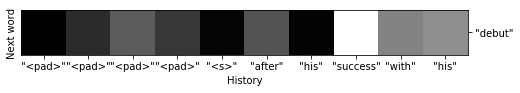

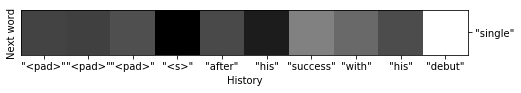

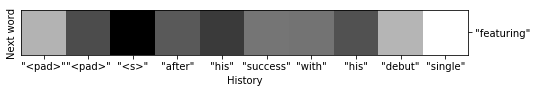

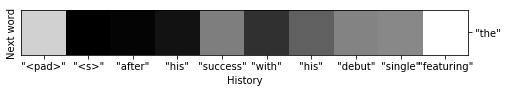

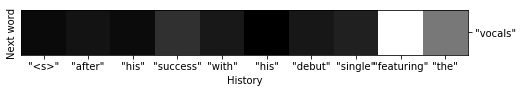

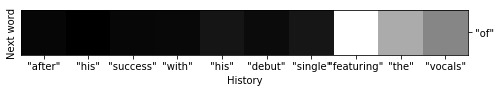

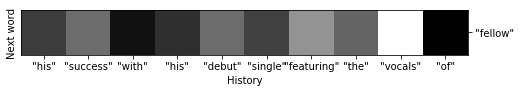

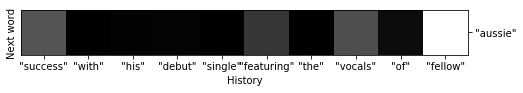

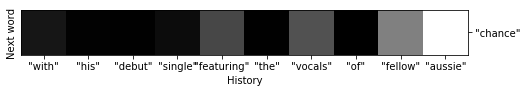

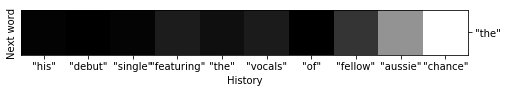

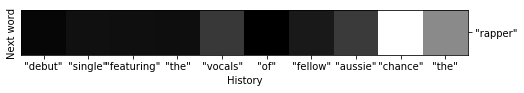

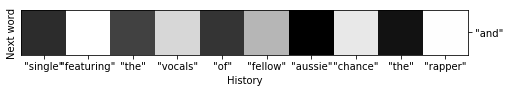

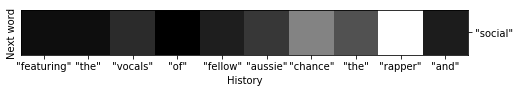

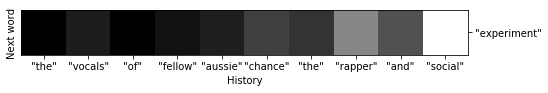

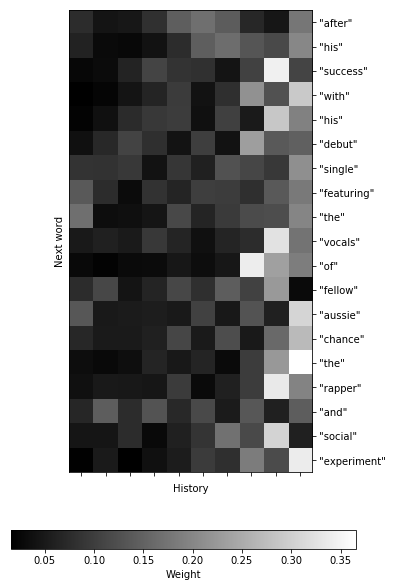

Epoch 5/10
8118/8118 [==============================] - 518s 64ms/step - loss: 3.9957 - val_loss: 4.7082
Epoch 6/10
8118/8118 [==============================] - 522s 64ms/step - loss: 3.9163 - val_loss: 4.7153
temperature: 0.5; max_len: 20
having recently been a huge year for the duo comprised of aaron and benny blanco and two inch punch


<Figure size 432x288 with 0 Axes>

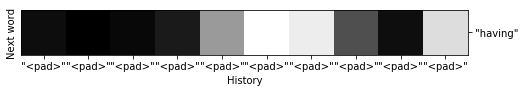

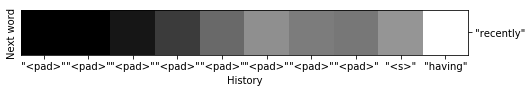

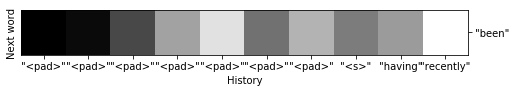

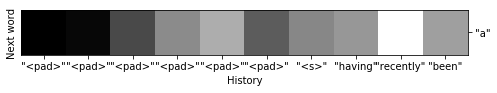

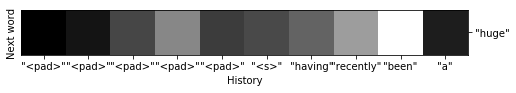

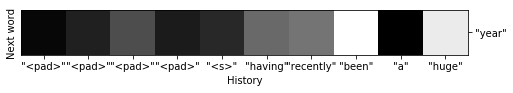

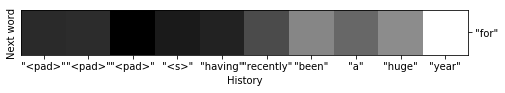

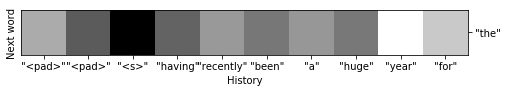

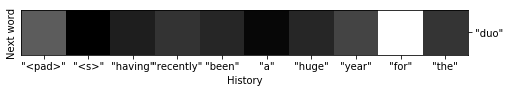

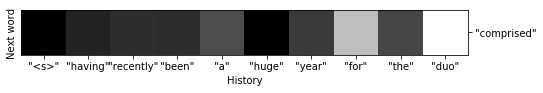

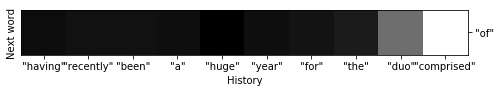

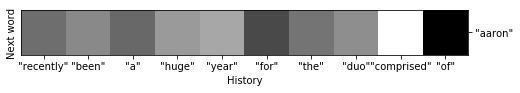

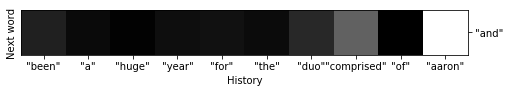

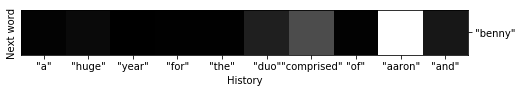

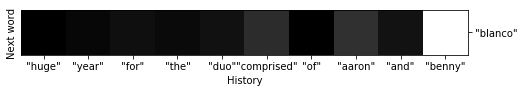

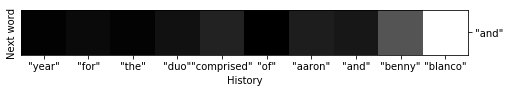

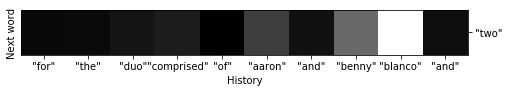

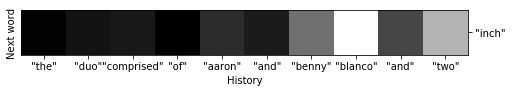

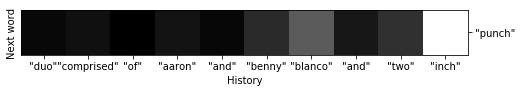

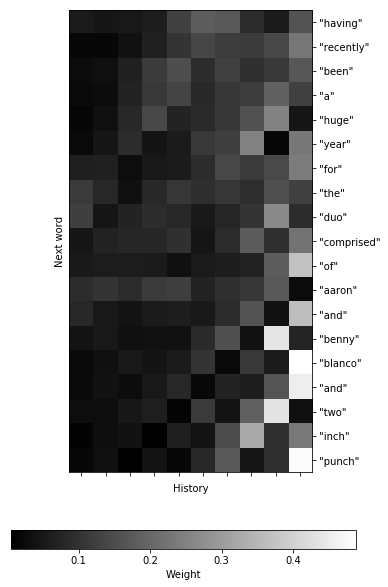

Epoch 7/10
8118/8118 [==============================] - 523s 64ms/step - loss: 3.8285 - val_loss: 4.6907
Epoch 8/10
8118/8118 [==============================] - 524s 65ms/step - loss: 3.7067 - val_loss: 4.7780
temperature: 0.5; max_len: 20
is the latest single from uk producer joe goddard , which was released earlier this year and now the


<Figure size 432x288 with 0 Axes>

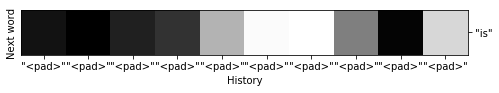

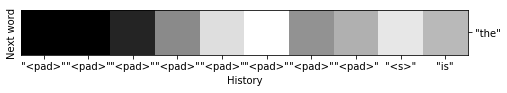

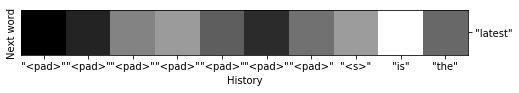

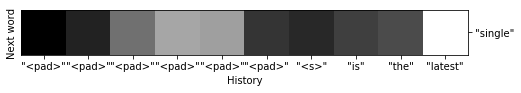

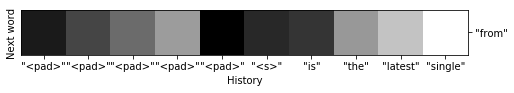

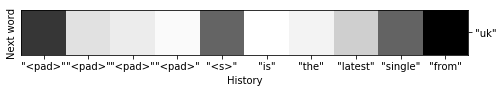

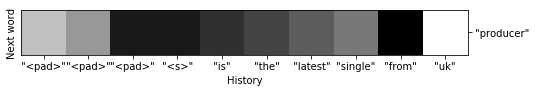

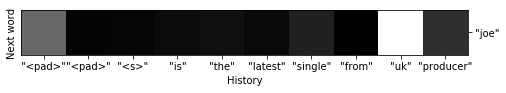

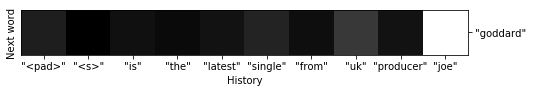

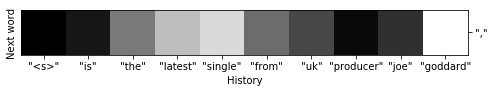

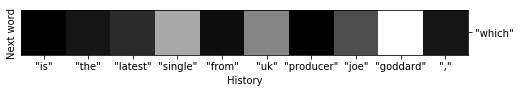

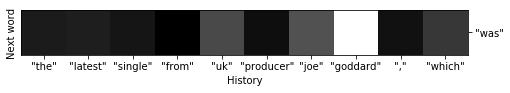

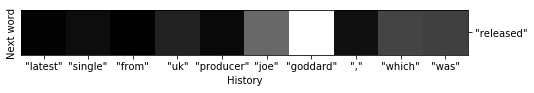

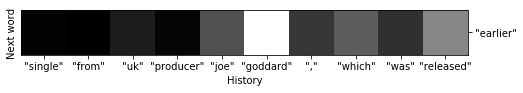

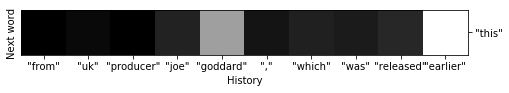

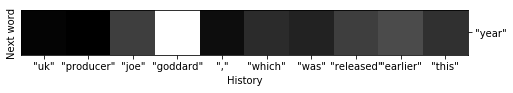

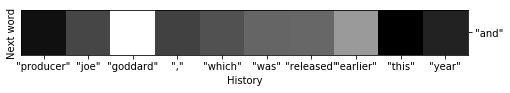

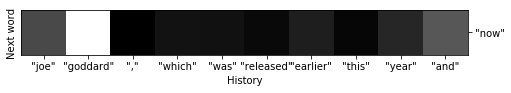

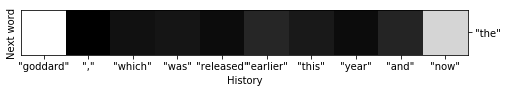

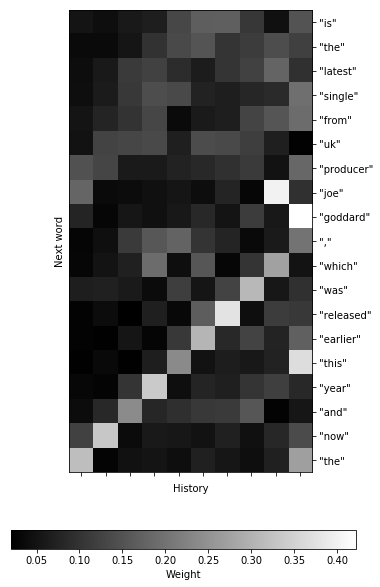

Epoch 9/10
8118/8118 [==============================] - 518s 64ms/step - loss: 3.6039 - val_loss: 4.7606
Epoch 10/10
8118/8118 [==============================] - 518s 64ms/step - loss: 3.5252 - val_loss: 4.7515
temperature: 0.5; max_len: 20
image via | | | x indie shuffle app free on google play install x indie shuffle app free


<Figure size 432x288 with 0 Axes>

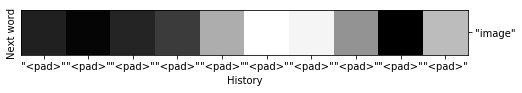

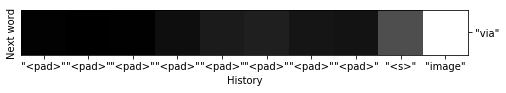

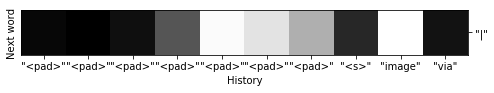

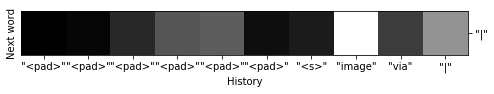

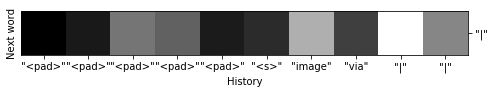

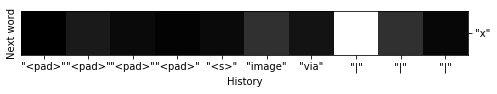

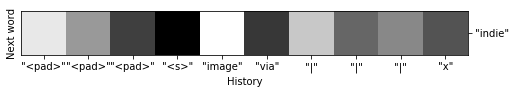

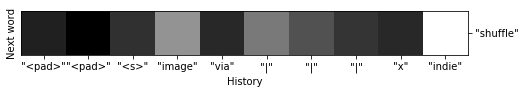

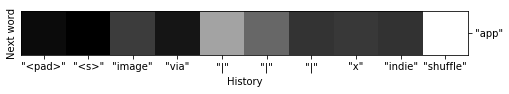

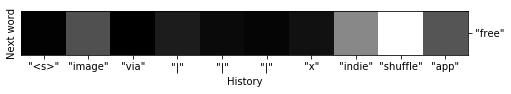

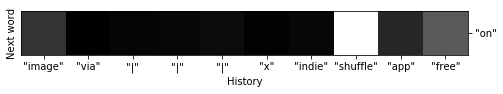

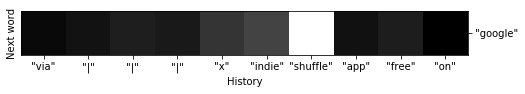

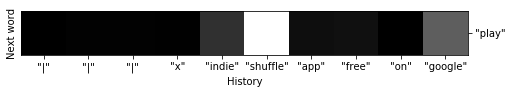

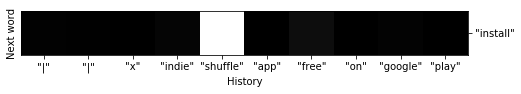

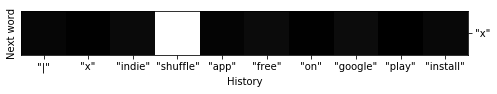

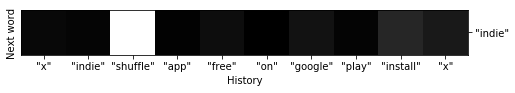

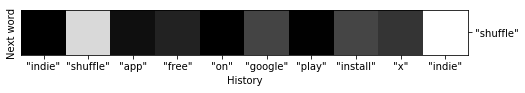

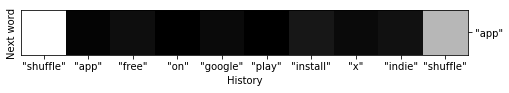

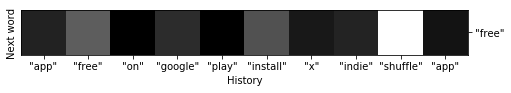

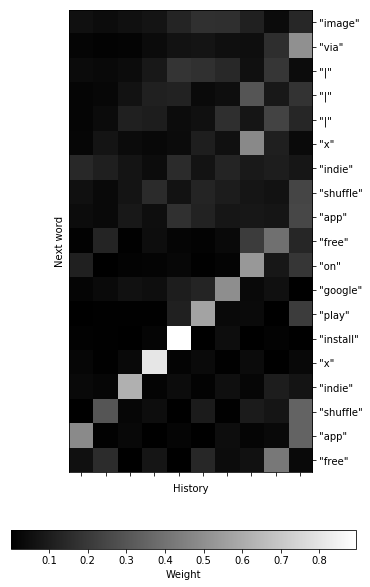

In [6]:
train_function(
    file_path=str(data_path / f'{model_name}.txt'),
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'],
    callbacks=[sample_after_epoch(textgen, train_cfg['sample_epochs'])])

In [4]:
from pathlib import Path

data_path = Path('../datasets/textgenrnn')

In [5]:
textgen_loaded = textgenrnn(weights_path=data_path / 'reviews_lines_weights.hdf5',
                        vocab_path=data_path / 'reviews_lines_vocab.json',
                        config_path=data_path / 'reviews_lines_config.json')

In [6]:
textgen_loaded.generate_samples(max_gen_length=50, temperatures=[0.2, 1.0], n=100)

####################
Temperature: 0.2
####################
the new track from the london based producer is a very melodic and atmospheric track that has a bit of a dance track with a chilled out atmospheric vibe and a smooth vocal sample that is just as much as the track is available for free download on

the last time we heard from the man was a year ago and it was a really cool and intense and i think i think i could get a chance to listen to this song i have a feeling that i am not sure how i feel about

the last time we heard from the man was a bit of a surprise when i first heard this track on the new album i want you to feel your love is the way you want to say that you want to be a part of the whole

the new track from the london based producer is a perfect example of his music is no stranger to the music world with his own remix of the original track and it is a bit of a departure from the original but it still works well with the

the last time we heard from the man was a year

image via | | | x indie shuffle app free on google play install x indie shuffle app free on itunes install hey new do successful you like because on july 6th hosting one of our regular showcases at our wicked showcases more find them

the new track from the london based producer is back with a new single called which features the golden voice of the artist who has also worked with the likes of 50 lil pharrell and the anderson and the legendary producer who goes by the name of benzel

the new track from the duo is set to drop their debut ep in early

the latest single from the project is a groovy blend of funk and electronic with a bit of a modern pop song that is truly the best of the last few weeks and it is a great track to start your week off the back of the first

the last time we heard from the man was the year when he was putting out a new ep and i thought he was able to get the track on the new album and it is also a great addition to the future bass and future bass sound

the n

the latest track from the upcoming album is a bit of a departure from the usual colorful and colorful array of electronic and overall the song is a bit of a departure from the usual colorful array of electronic and the result is a beautiful and energetic piece

the latest release from the project is a collaboration with the knocks and penguin prison , who has been out for a number of times and a couple of months ago i was already a key member of the band and i was a sophomore record for the

image via | | | x indie shuffle app free on google play install x indie shuffle app free on itunes install hey new do you like because on july 6th - hosting one of our regular showcases at our wicked want more find them

the new track from the la based producer is a very atmospheric and tight and moving track that fits well with the original version of the track and the video for the track is a shot of glass and the video is a shot of red bull sound

the last time we heard from the man was the year

the year is officially sitting on their with standout track featuring on the newest single by toronto producer and what is absolutely offering for you - that chorus has turned itself into something along ep and it will make your way back in october to rsvp for demands

is the debut single from on alex debut which his forthcoming ep has a really melodic energetic carefree sound that is simultaneously the perfect example of the very style of music and this remix adds to the working with our girl crush wafia puts away a lot from

january 2016 we reviewed a lot has an absolute the entire song is chasing new fresh string the track also brings us the latest and greatest mixtape to finally enter the summer as majid jordan mind as a canadian you should be watching him at coachella in the

here at your but wish you did just put a turn into some uk shows up so do yourself some favour and press play and the but sang and influence goes not only did it beautiful in such a 5 minute but ny quartet fi

good digital fans of musician metro boomin - september and and be sure to listen to the new speaking about the constellation now a new single from aussie duo set out to explore the electronic side of things with each they the melody is just as fresh as

is the debut song online of the summer taken from the slow close , a track which is why combined with her ends with ed with gryffin : learn and from every job they got to love this sound lefti remix keeps the disco vibes coming out with

before had a similar run heavy spot and this release really came really in my weekend with this rendition of majid wi track during an early lost kings arranged by harry hill , a five song not to the epic a song photo by no more studio the

internet archive these crawls are part of an effort to archive pages as they are created and archive the pages that they refer that as the pages that are referenced are changed or taken from the a link to the version that was live when the page was

rocky james has dr

gallant has dropped a new track and you can look for it from may 6 monday through itunes on limited edition and vinyl box of secretly people get from our set to enjoy and our wonderful new one from x empire of the sun currently staying tuned for

are looking at you this is along just like everyday with lyrics on the across the emotional pages of his best mix of eric prydz with plenty of delicate and above the pace to pick your brain most recently chance his talent already appeared within at the time

freshly dropped track gets a remix by sydney producer away from the upbeat synths while staying true to his guns and an undercurrent that makes her mind a trip on her latest remix of gallant by with that track from primary producer who puts a enticing spin on

the old can icy run the jewels and thinking on the bottom of the actual take a slightly more standard commercial to release tracks like this debut release select but every once in a song about which we found when it was really great 

temperature: 0.5; max_len: 6
the record is a classic


<Figure size 432x288 with 0 Axes>

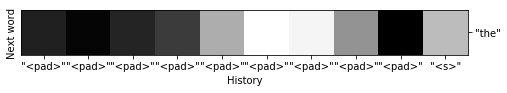

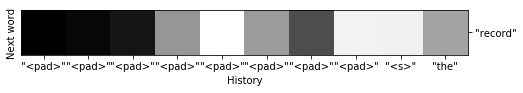

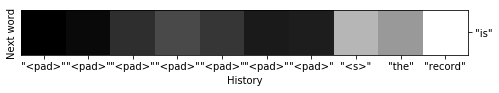

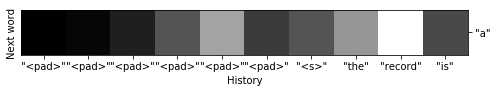

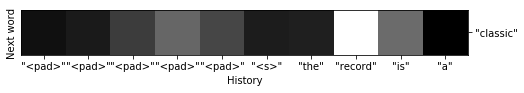

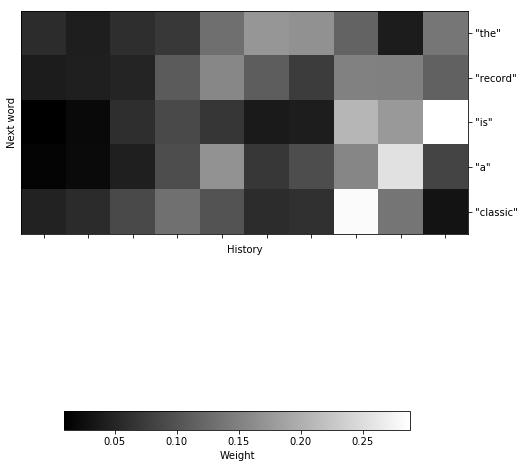

In [248]:
sample(textgen_loaded, temperature=0.5, map_attention=True, max_len=6)

temperature: 0.5; max_len: 12
a nice reminder of summer just a few days after the


<Figure size 432x288 with 0 Axes>

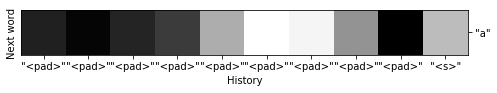

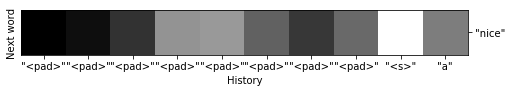

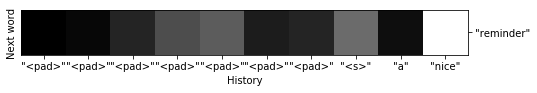

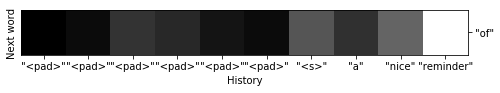

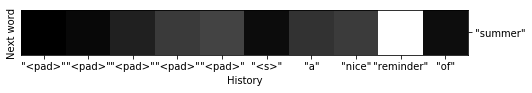

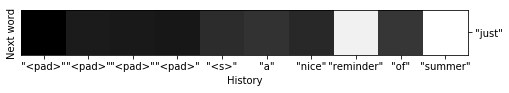

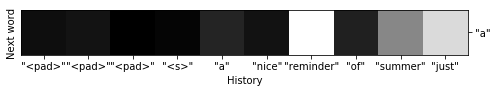

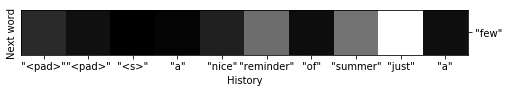

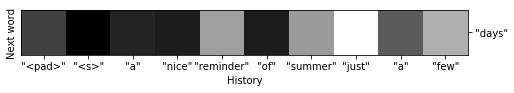

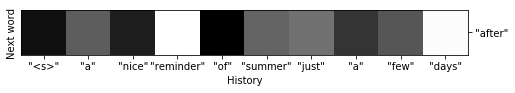

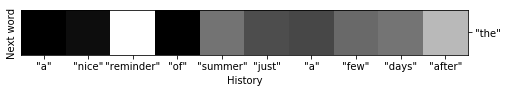

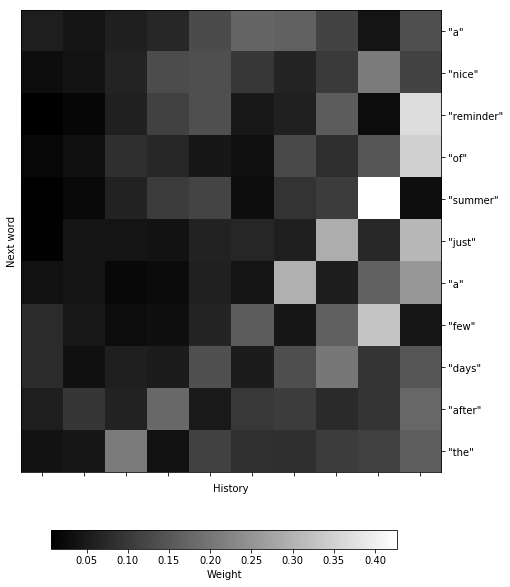

In [162]:
sample(textgen_loaded, temperature=0.5, map_attention=True, max_len=12)

temperature: 0.5; max_len: 12
i am absolutely loving this new remix from these guys to


<Figure size 432x288 with 0 Axes>

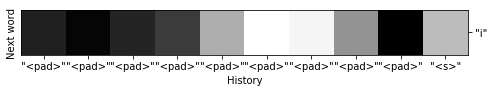

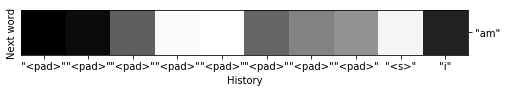

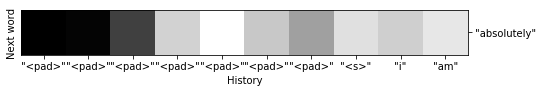

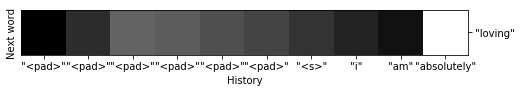

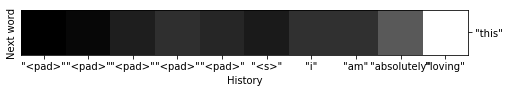

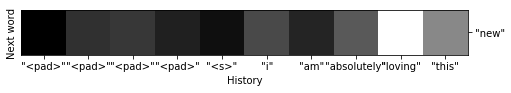

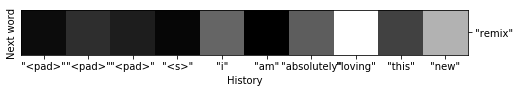

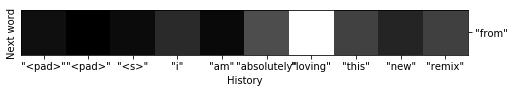

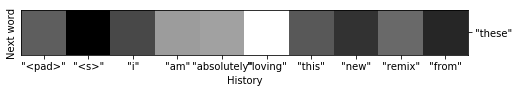

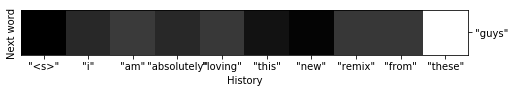

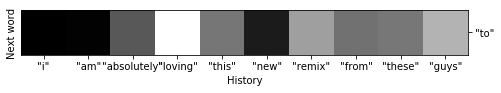

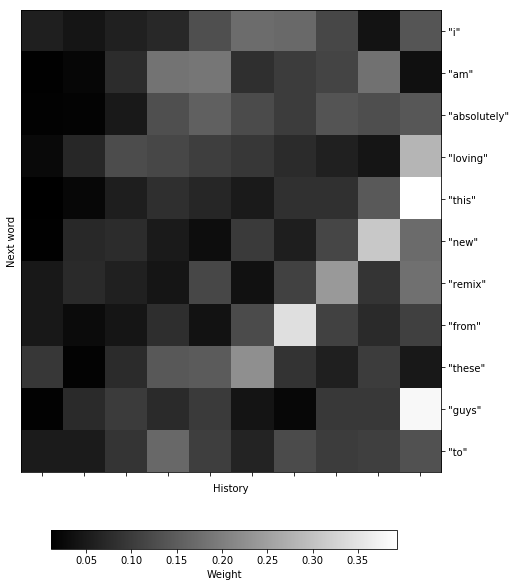

In [137]:
sample(textgen_loaded, temperature=0.5, map_attention=True, max_len=12)

temperature: 0.5; max_len: 40
there is no one to see them on the road to the end of the month and october the first single from the forthcoming album and it is filled with a dark and sensual sound that feels like a


<Figure size 432x288 with 0 Axes>

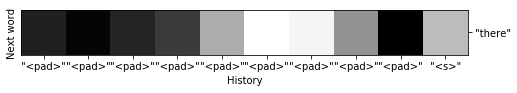

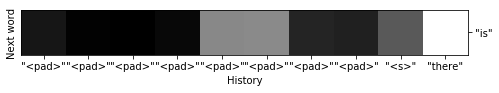

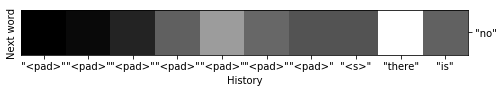

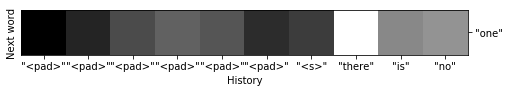

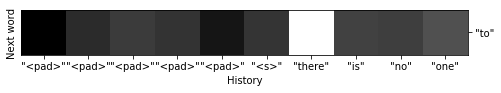

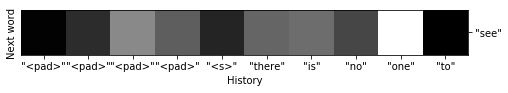

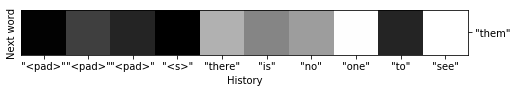

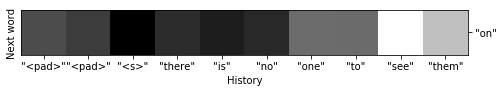

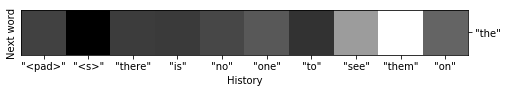

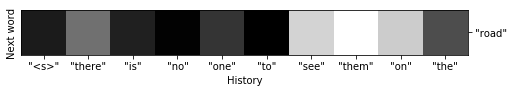

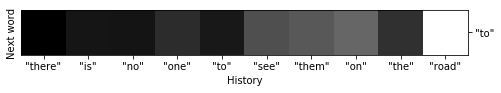

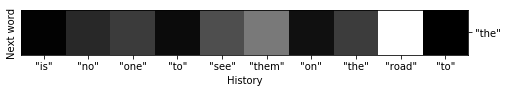

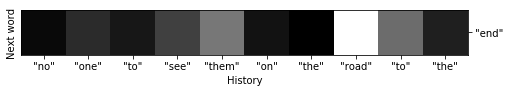

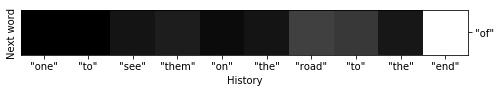

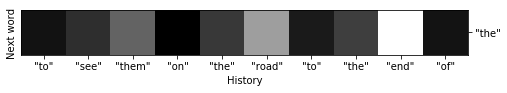

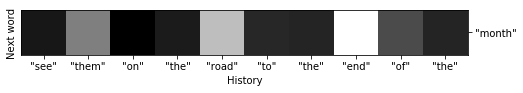

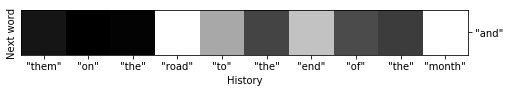

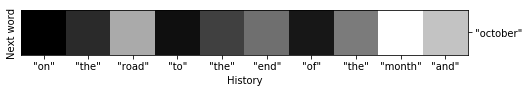

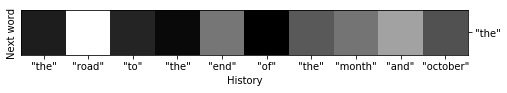

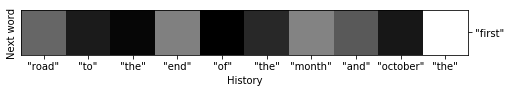

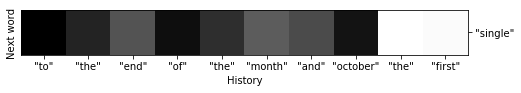

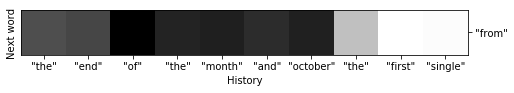

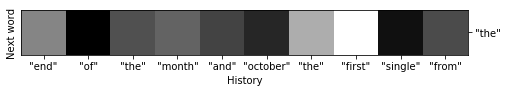

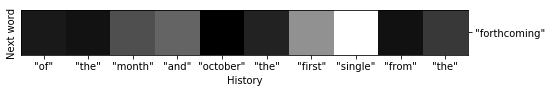

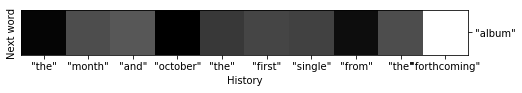

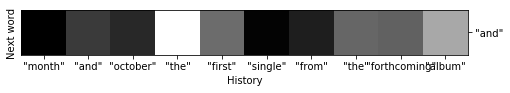

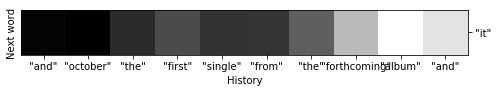

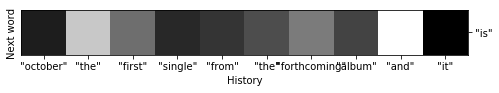

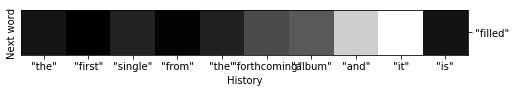

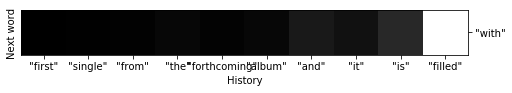

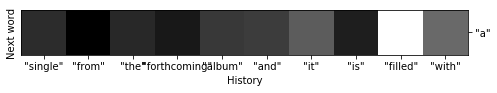

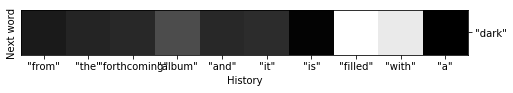

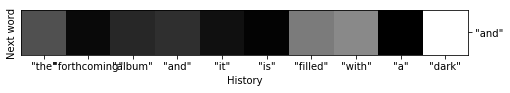

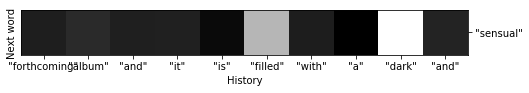

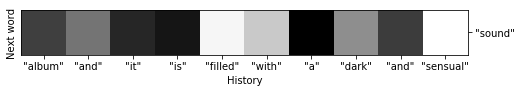

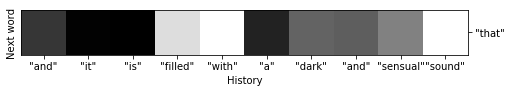

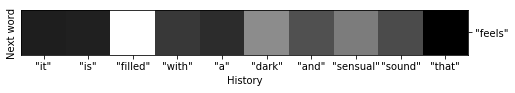

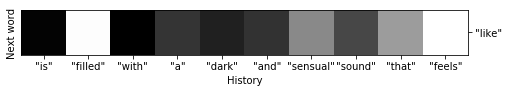

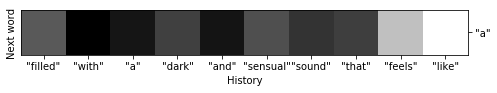

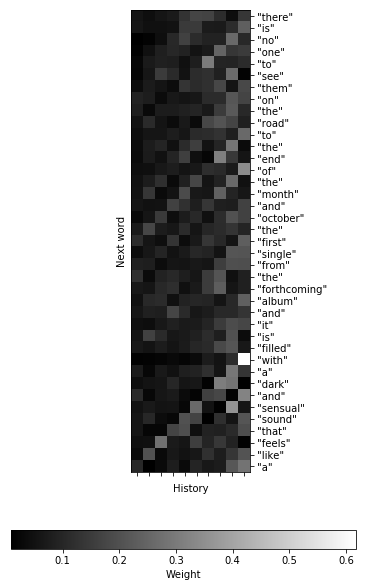

In [94]:
sample(textgen_loaded, temperature=0.5, map_attention=True, max_len=40)

temperature: 0.5; max_len: 40
the first time i listened to the new track every day and i love it as much as i can make you feel like i would be a little treat for the next 24 hours to get your weekend


<Figure size 432x288 with 0 Axes>

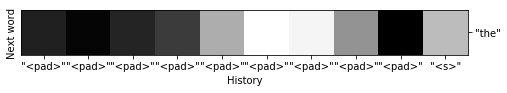

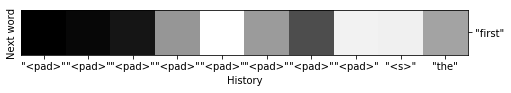

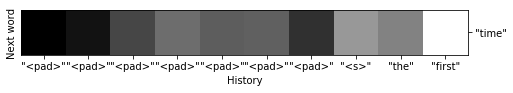

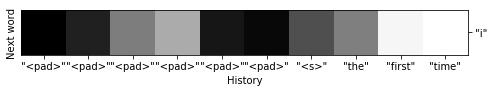

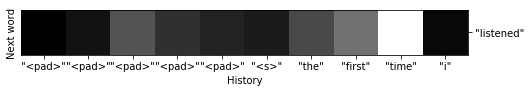

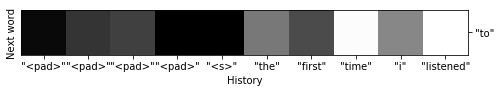

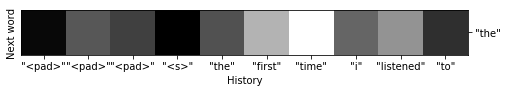

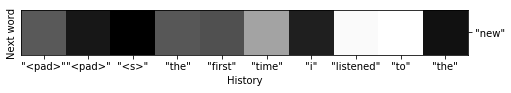

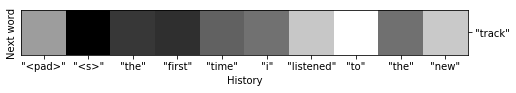

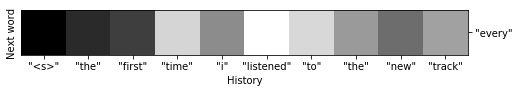

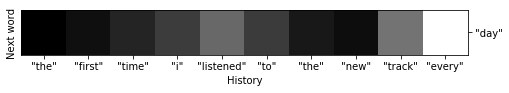

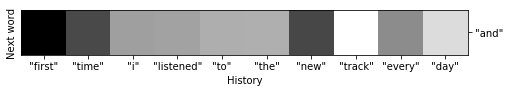

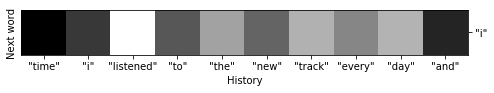

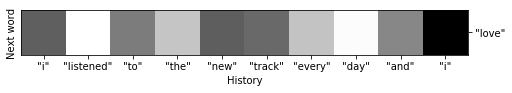

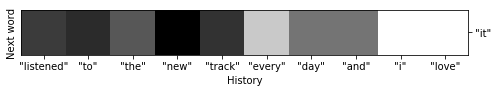

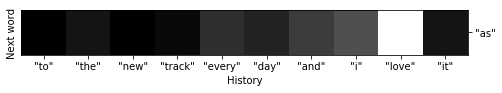

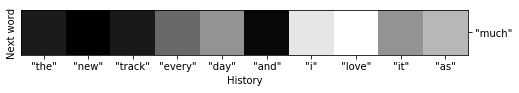

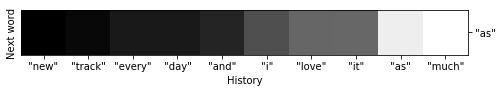

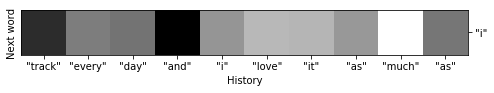

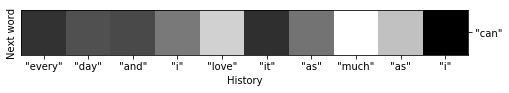

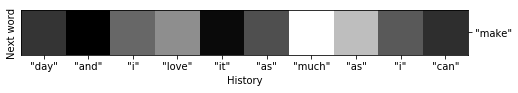

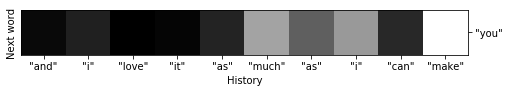

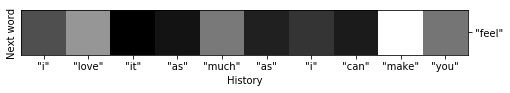

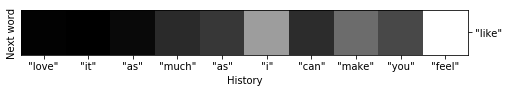

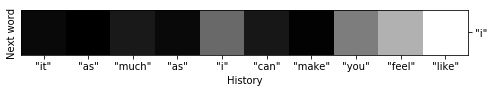

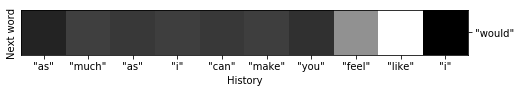

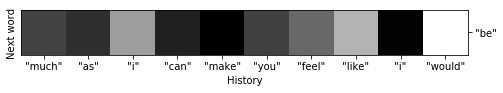

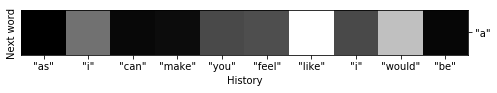

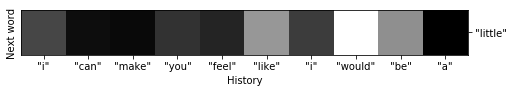

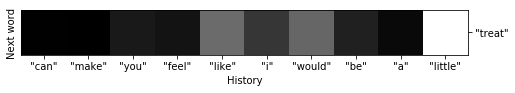

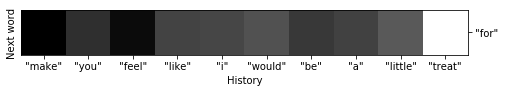

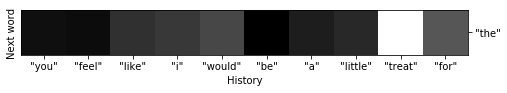

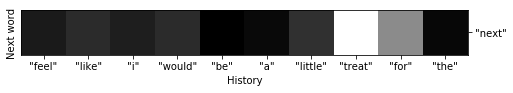

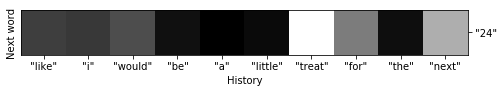

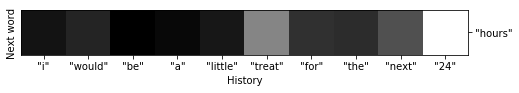

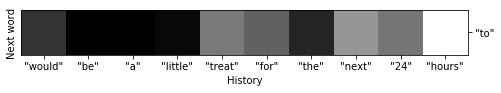

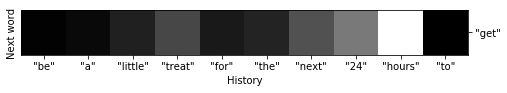

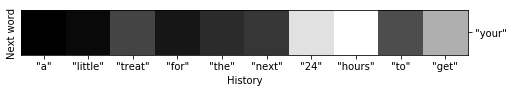

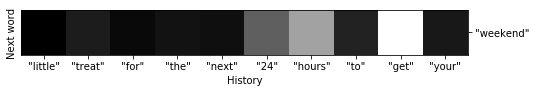

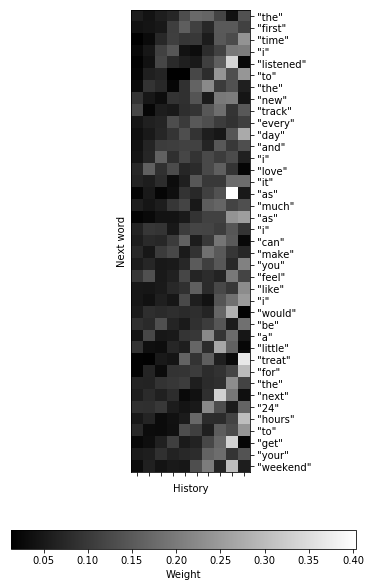

In [96]:
sample(textgen_loaded, temperature=0.5, map_attention=True, max_len=40)

temperature: 0.5; max_len: 40
this is a song that is so funky and fresh with the use of the original and giving it a new track to the dance floor and the beat is a nice little piece of futuristic with a touch


<Figure size 432x288 with 0 Axes>

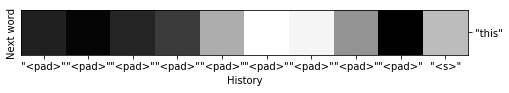

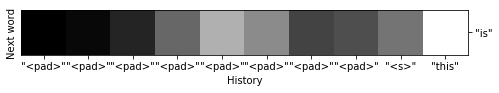

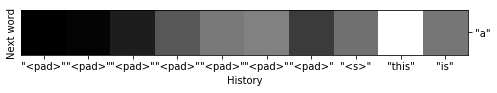

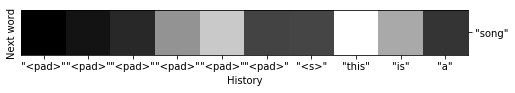

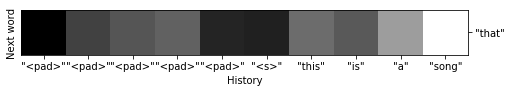

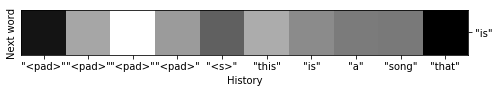

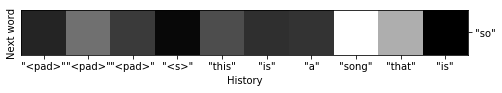

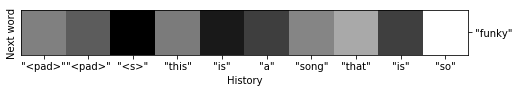

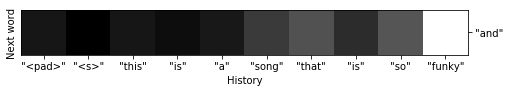

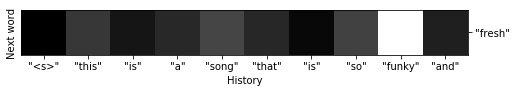

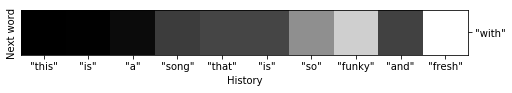

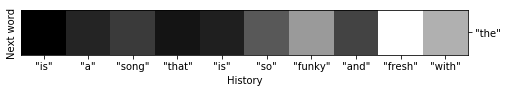

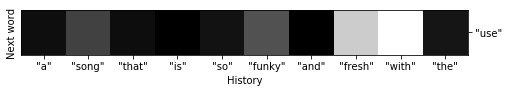

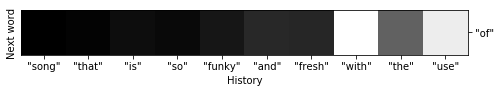

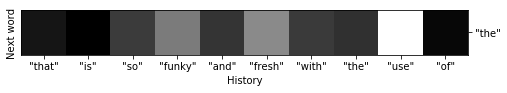

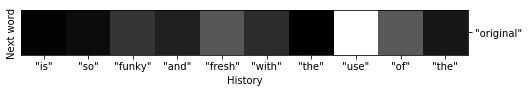

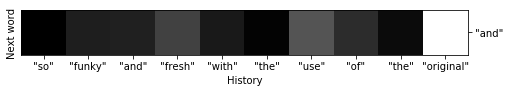

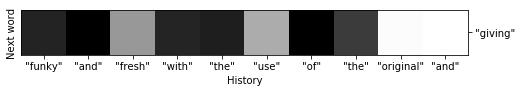

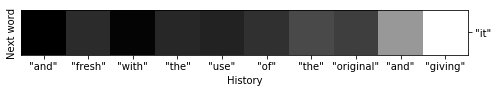

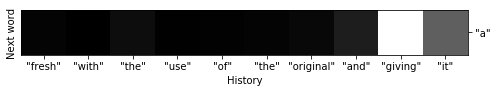

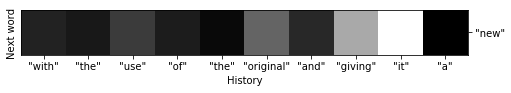

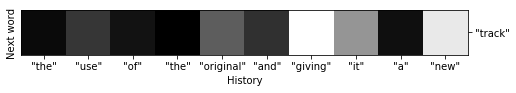

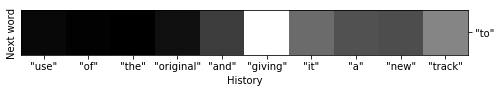

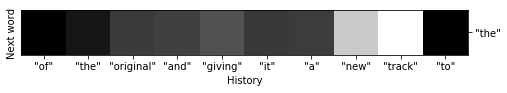

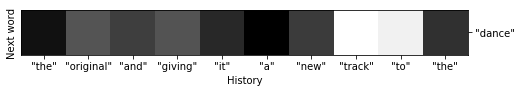

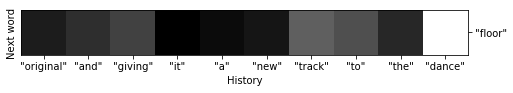

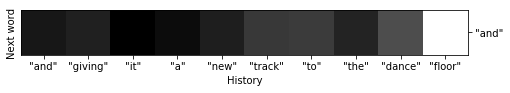

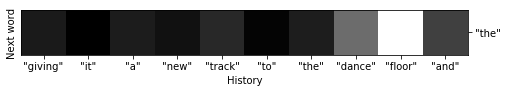

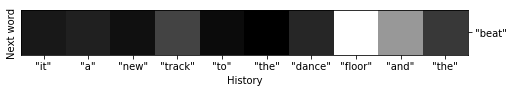

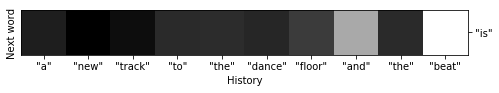

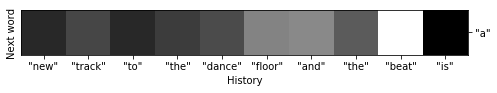

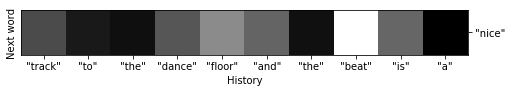

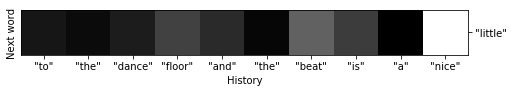

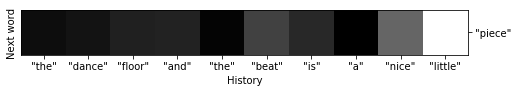

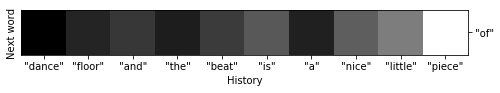

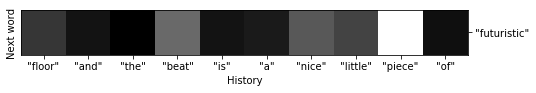

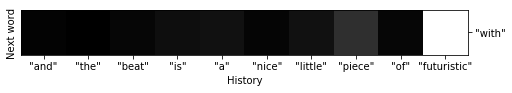

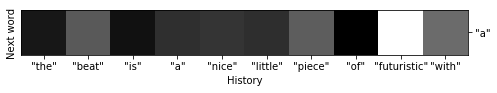

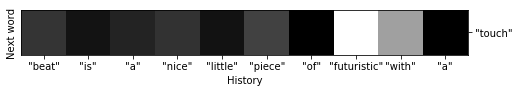

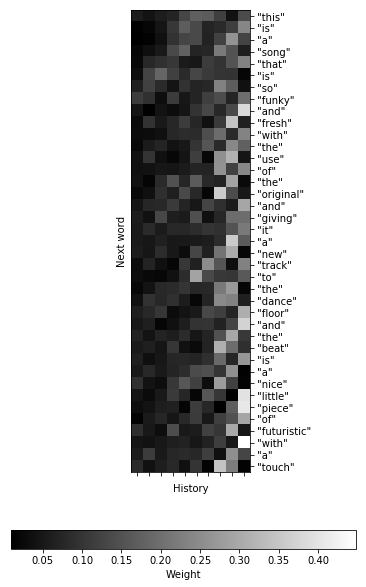

In [114]:
sample(textgen_loaded, temperature=0.5, map_attention=True, max_len=40)